<a href="https://www.bigdatauniversity.com"><img src="https://ibm.box.com/shared/static/cw2c7r3o20w9zn8gkecaeyjhgw3xdgbj.png" width="400" align="center"></a>

<h1 align="center"><font size="5">Classification with Python</font></h1>

In this notebook we try to practice all the classification algorithms that we learned in this course.

We load a dataset using Pandas library, and apply the following algorithms, and find the best one for this specific dataset by accuracy evaluation methods.

Lets first load required libraries:

In [1]:
import itertools
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import NullFormatter
import pandas as pd
import numpy as np
import matplotlib.ticker as ticker
from sklearn import preprocessing
%matplotlib inline

### About dataset

This dataset is about past loans. The __Loan_train.csv__ data set includes details of 346 customers whose loan are already paid off or defaulted. It includes following fields:

| Field          | Description                                                                           |
|----------------|---------------------------------------------------------------------------------------|
| Loan_status    | Whether a loan is paid off on in collection                                           |
| Principal      | Basic principal loan amount at the                                                    |
| Terms          | Origination terms which can be weekly (7 days), biweekly, and monthly payoff schedule |
| Effective_date | When the loan got originated and took effects                                         |
| Due_date       | Since it’s one-time payoff schedule, each loan has one single due date                |
| Age            | Age of applicant                                                                      |
| Education      | Education of applicant                                                                |
| Gender         | The gender of applicant                                                               |

Lets download the dataset

In [2]:
!wget -O loan_train.csv https://s3-api.us-geo.objectstorage.softlayer.net/cf-courses-data/CognitiveClass/ML0101ENv3/labs/loan_train.csv

--2020-08-04 13:50:46--  https://s3-api.us-geo.objectstorage.softlayer.net/cf-courses-data/CognitiveClass/ML0101ENv3/labs/loan_train.csv
Resolving s3-api.us-geo.objectstorage.softlayer.net (s3-api.us-geo.objectstorage.softlayer.net)... 67.228.254.196
Connecting to s3-api.us-geo.objectstorage.softlayer.net (s3-api.us-geo.objectstorage.softlayer.net)|67.228.254.196|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 23101 (23K) [text/csv]
Saving to: ‘loan_train.csv’

100%[======================================>] 23,101      --.-K/s   in 0.002s  

2020-08-04 13:50:46 (14.6 MB/s) - ‘loan_train.csv’ saved [23101/23101]



### Load Data From CSV File  

In [3]:
df = pd.read_csv('loan_train.csv')
df.head()

,Unnamed: 0,Unnamed: 0.1,loan_status,Principal,terms,effective_date,due_date,age,education,Gender
0,0,0,PAIDOFF,1000,30,9/8/2016,10/7/2016,45,High School or Below,male
1,2,2,PAIDOFF,1000,30,9/8/2016,10/7/2016,33,Bechalor,female
2,3,3,PAIDOFF,1000,15,9/8/2016,9/22/2016,27,college,male
3,4,4,PAIDOFF,1000,30,9/9/2016,10/8/2016,28,college,female
4,6,6,PAIDOFF,1000,30,9/9/2016,10/8/2016,29,college,male


In [4]:
df.shape

(346, 10)

### Convert to date time object 

In [5]:
df['due_date'] = pd.to_datetime(df['due_date'])
df['effective_date'] = pd.to_datetime(df['effective_date'])
df.head()

,Unnamed: 0,Unnamed: 0.1,loan_status,Principal,terms,effective_date,due_date,age,education,Gender
0,0,0,PAIDOFF,1000,30,2016-09-08,2016-10-07,45,High School or Below,male
1,2,2,PAIDOFF,1000,30,2016-09-08,2016-10-07,33,Bechalor,female
2,3,3,PAIDOFF,1000,15,2016-09-08,2016-09-22,27,college,male
3,4,4,PAIDOFF,1000,30,2016-09-09,2016-10-08,28,college,female
4,6,6,PAIDOFF,1000,30,2016-09-09,2016-10-08,29,college,male


# Data visualization and pre-processing



Let’s see how many of each class is in our data set 

In [6]:
df['loan_status'].value_counts()

PAIDOFF       260
COLLECTION     86
Name: loan_status, dtype: int64

260 people have paid off the loan on time while 86 have gone into collection 


Lets plot some columns to underestand data better:

In [7]:
# notice: installing seaborn might takes a few minutes
!conda install -c anaconda seaborn -y

Solving environment: done

# All requested packages already installed.



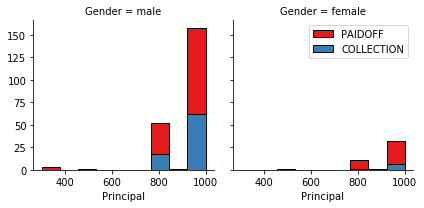

In [8]:
import seaborn as sns

bins = np.linspace(df.Principal.min(), df.Principal.max(), 10)
g = sns.FacetGrid(df, col="Gender", hue="loan_status", palette="Set1", col_wrap=2)
g.map(plt.hist, 'Principal', bins=bins, ec="k")

g.axes[-1].legend()
plt.show()

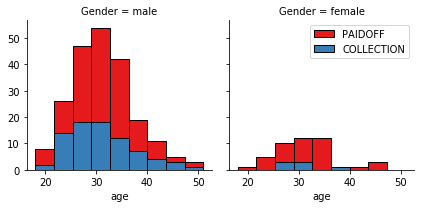

In [9]:
bins = np.linspace(df.age.min(), df.age.max(), 10)
g = sns.FacetGrid(df, col="Gender", hue="loan_status", palette="Set1", col_wrap=2)
g.map(plt.hist, 'age', bins=bins, ec="k")

g.axes[-1].legend()
plt.show()

# Pre-processing:  Feature selection/extraction

### Lets look at the day of the week people get the loan 

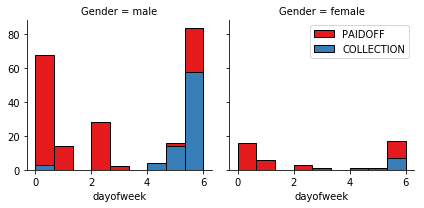

In [10]:
df['dayofweek'] = df['effective_date'].dt.dayofweek
bins = np.linspace(df.dayofweek.min(), df.dayofweek.max(), 10)
g = sns.FacetGrid(df, col="Gender", hue="loan_status", palette="Set1", col_wrap=2)
g.map(plt.hist, 'dayofweek', bins=bins, ec="k")
g.axes[-1].legend()
plt.show()


We see that people who get the loan at the end of the week dont pay it off, so lets use Feature binarization to set a threshold values less then day 4 

In [11]:
df['weekend'] = df['dayofweek'].apply(lambda x: 1 if (x>3)  else 0)
df.head()

,Unnamed: 0,Unnamed: 0.1,loan_status,Principal,terms,effective_date,due_date,age,education,Gender,dayofweek,weekend
0,0,0,PAIDOFF,1000,30,2016-09-08,2016-10-07,45,High School or Below,male,3,0
1,2,2,PAIDOFF,1000,30,2016-09-08,2016-10-07,33,Bechalor,female,3,0
2,3,3,PAIDOFF,1000,15,2016-09-08,2016-09-22,27,college,male,3,0
3,4,4,PAIDOFF,1000,30,2016-09-09,2016-10-08,28,college,female,4,1
4,6,6,PAIDOFF,1000,30,2016-09-09,2016-10-08,29,college,male,4,1


## Convert Categorical features to numerical values

Lets look at gender:

In [12]:
df.groupby(['Gender'])['loan_status'].value_counts(normalize=True)

Gender  loan_status
female  PAIDOFF        0.865385
        COLLECTION     0.134615
male    PAIDOFF        0.731293
        COLLECTION     0.268707
Name: loan_status, dtype: float64

86 % of female pay there loans while only 73 % of males pay there loan


Lets convert male to 0 and female to 1:


In [13]:
df['Gender'].replace(to_replace=['male','female'], value=[0,1],inplace=True)
df.head()

,Unnamed: 0,Unnamed: 0.1,loan_status,Principal,terms,effective_date,due_date,age,education,Gender,dayofweek,weekend
0,0,0,PAIDOFF,1000,30,2016-09-08,2016-10-07,45,High School or Below,0,3,0
1,2,2,PAIDOFF,1000,30,2016-09-08,2016-10-07,33,Bechalor,1,3,0
2,3,3,PAIDOFF,1000,15,2016-09-08,2016-09-22,27,college,0,3,0
3,4,4,PAIDOFF,1000,30,2016-09-09,2016-10-08,28,college,1,4,1
4,6,6,PAIDOFF,1000,30,2016-09-09,2016-10-08,29,college,0,4,1


## One Hot Encoding  
#### How about education?

In [14]:
df.groupby(['education'])['loan_status'].value_counts(normalize=True)

education             loan_status
Bechalor              PAIDOFF        0.750000
                      COLLECTION     0.250000
High School or Below  PAIDOFF        0.741722
                      COLLECTION     0.258278
Master or Above       COLLECTION     0.500000
                      PAIDOFF        0.500000
college               PAIDOFF        0.765101
                      COLLECTION     0.234899
Name: loan_status, dtype: float64

#### Feature before One Hot Encoding

In [15]:
df[['Principal','terms','age','Gender','education']].head()

,Principal,terms,age,Gender,education
0,1000,30,45,0,High School or Below
1,1000,30,33,1,Bechalor
2,1000,15,27,0,college
3,1000,30,28,1,college
4,1000,30,29,0,college


#### Use one hot encoding technique to convert categorical variables to binary variables and append them to the feature Data Frame 

In [16]:
Feature = df[['Principal','terms','age','Gender','weekend']]
Feature = pd.concat([Feature,pd.get_dummies(df['education'])], axis=1)
Feature.drop(['Master or Above'], axis = 1,inplace=True)
Feature.head()


,Principal,terms,age,Gender,weekend,Bechalor,High School or Below,college
0,1000,30,45,0,0,0,1,0
1,1000,30,33,1,0,1,0,0
2,1000,15,27,0,0,0,0,1
3,1000,30,28,1,1,0,0,1
4,1000,30,29,0,1,0,0,1


### Feature selection

Lets define feature sets, X:

In [17]:
X = Feature
X[0:5]

,Principal,terms,age,Gender,weekend,Bechalor,High School or Below,college
0,1000,30,45,0,0,0,1,0
1,1000,30,33,1,0,1,0,0
2,1000,15,27,0,0,0,0,1
3,1000,30,28,1,1,0,0,1
4,1000,30,29,0,1,0,0,1


What are our labels?

In [18]:
y = df['loan_status'].values
y[0:5]

array(['PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF'],
      dtype=object)

## Normalize Data 

Data Standardization give data zero mean and unit variance (technically should be done after train test split )

In [19]:
X= preprocessing.StandardScaler().fit(X).transform(X)
X[0:5]

/opt/conda/envs/Python36/lib/python3.6/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype uint8, int64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/opt/conda/envs/Python36/lib/python3.6/site-packages/ipykernel/__main__.py:1: DataConversionWarning: Data with input dtype uint8, int64 were all converted to float64 by StandardScaler.
  if __name__ == '__main__':


array([[ 0.51578458,  0.92071769,  2.33152555, -0.42056004, -1.20577805,
        -0.38170062,  1.13639374, -0.86968108],
       [ 0.51578458,  0.92071769,  0.34170148,  2.37778177, -1.20577805,
         2.61985426, -0.87997669, -0.86968108],
       [ 0.51578458, -0.95911111, -0.65321055, -0.42056004, -1.20577805,
        -0.38170062, -0.87997669,  1.14984679],
       [ 0.51578458,  0.92071769, -0.48739188,  2.37778177,  0.82934003,
        -0.38170062, -0.87997669,  1.14984679],
       [ 0.51578458,  0.92071769, -0.3215732 , -0.42056004,  0.82934003,
        -0.38170062, -0.87997669,  1.14984679]])

# Classification 

Now, it is your turn, use the training set to build an accurate model. Then use the test set to report the accuracy of the model
You should use the following algorithm:
- K Nearest Neighbor(KNN)
- Decision Tree
- Support Vector Machine
- Logistic Regression



__ Notice:__ 
- You can go above and change the pre-processing, feature selection, feature-extraction, and so on, to make a better model.
- You should use either scikit-learn, Scipy or Numpy libraries for developing the classification algorithms.
- You should include the code of the algorithm in the following cells.

# K Nearest Neighbor(KNN)
Notice: You should find the best k to build the model with the best accuracy.  
**warning:** You should not use the __loan_test.csv__ for finding the best k, however, you can split your train_loan.csv into train and test to find the best __k__.

## Strategy
In order to train the classification models in this project, the strategy will be to split the original data into train (80% of samples) and test (20% of samples) data sets. This is a good technique for avoiding overfitting in the model, and will provide more realistic assessment of the algorithm performance for predicting out-of-sample values.

On the other hand, by not using the full data set, we may not be able to capture all the information present in the data and thus could get an overfitted model. 

So, I'm going to use Cross Validation, which splits the data into "partitions" and runs the algorithm multiple times, using one partition as the test set and the others as the training set, until all combinations are done. Then, the scores will be averaged to obtain a more realistic generalization performance of the algorithm.

## Evaluation
These are the typical metrics for evaluating classification models:

| Metric      | Description |
|:-------------:|:-------------|
| precision   | Defined by the formula TP /(TP + FP), is a mesure of the accuracy for predicting the specific class (COLLECTION and PAIDOFF)  |
| recall      | Defined by the formula TP / (TP + FN), is the true positive rate for the specific class (COLLECTION and PAIDOFF)    |
| f1score    | Is the harmonic average between the precision and recall of each class. It is a good way to see if the classifier has both a good precision and recall, and ranges from 0 to 1 (0 = worst, 1 = best) |
| weighted_f1score | Weighted average between the COLLECTION and PAIDOFF f1-scores, according to their frequencies       |

The **weighted_f1score** metric will be used for evaluating the models, since it is capable of combining precision and recall performance for both classes (COLLECTION and PAIDOFF) in our case. I want the model to be good at predicting both COLLECTION and PAIDOFF cases.

In [20]:
from sklearn.model_selection import cross_val_score
import warnings
# ignore warnings for the f1-score calculations when the test set doesn't allow calculation
# for some class
warnings.filterwarnings('ignore')

# This function runs the cross validation on the model, using 5 partitions 
# (1/5 of data for test set, 4/5 for train set), print the Weighted F1-score
# for each iteration, and the mean f1-score from all iterations.
# Returns the mean f1-score
def eval_model(model, X_data, y_data, message) :
    """ 
    This function runs the cross validation on the model provided, using 5 partitions
    (1/5 of data for test set, 4/5 for train set)
    """
    scores = cross_val_score(model, X_data, y_data, scoring='f1_weighted', cv=5)
    mean_score = scores.mean()
    print(f"{message}: scores={scores}  mean_f1score={mean_score}")
    return mean_score


In [21]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn import metrics

# Create lists for storing the iteration data
k_values = []
mean_f1scores = []

min_k = 1
max_k = 20

# Iterate the values of k (number of neighbors)
for k in range(min_k, max_k+1):
    # Create a KNN classifier and evaluate with cross validation
    knn = KNeighborsClassifier(n_neighbors = k)
    mean_score = eval_model(knn, X, y, f"KNN(k={k})")
       
    k_values.append(k)
    mean_f1scores.append(mean_score)

KNN(k=1): scores=[0.57018634 0.53703081 0.71014493 0.82494088 0.71049747]  mean_f1score=0.6705600849530381
KNN(k=2): scores=[0.49610767 0.49582356 0.67080745 0.805119   0.82494088]  mean_f1score=0.6585597129405605
KNN(k=3): scores=[0.63458647 0.53364389 0.71908683 0.78765163 0.73812331]  mean_f1score=0.6826184253458145
KNN(k=4): scores=[0.58494949 0.4729238  0.77228379 0.82494088 0.8312357 ]  mean_f1score=0.6972667326954318
KNN(k=5): scores=[0.64918726 0.62996116 0.73803465 0.76374511 0.71049747]  mean_f1score=0.698285131790371
KNN(k=6): scores=[0.62517483 0.47376312 0.76811594 0.8312357  0.81008192]  mean_f1score=0.7016742998298102
KNN(k=7): scores=[0.70119048 0.54913522 0.76128302 0.76374511 0.76374511]  mean_f1score=0.7078197891589941
KNN(k=8): scores=[0.61168014 0.41694684 0.75995238 0.78765163 0.78765163]  mean_f1score=0.6727765231844595
KNN(k=9): scores=[0.61969697 0.48519219 0.74959533 0.73812331 0.76374511]  mean_f1score=0.6712705822426754
KNN(k=10): scores=[0.55577498 0.425937

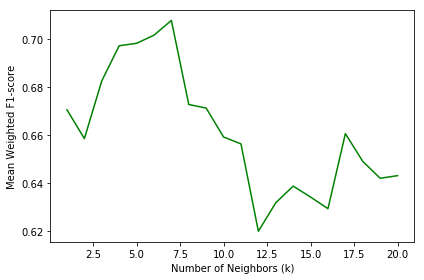

In [22]:
# Plot the accuracy of the model as a function of k, to analyze if there is a trend
plt.plot(k_values, mean_f1scores,'g')
plt.ylabel('Mean Weighted F1-score')
plt.xlabel('Number of Neighbors (k)')
plt.tight_layout()
plt.show()


In [23]:
# Determine the highest k/score pair
max_score = 0.0
best_k = 0
for k, score in zip(k_values, mean_f1scores) :
    if score > max_score :
        max_score = score
        best_k = k
        
print(f"The best k is {best_k} => Mean F1-score is {max_score}")

The best k is 7 => Mean F1-score is 0.7078197891589941


In [24]:
# Create the KNN model with the best K 
knn_final = KNeighborsClassifier(n_neighbors = best_k)

# Train the model with the full dataset
knn_final.fit( X, y )

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=None, n_neighbors=7, p=2,
           weights='uniform')

## Analysis - KNN
Using the strategy to evaluate each model by cross validation and averaging the weighted F1-score of each run, the best KNN model was achieved with **k=7** neighbors, and an average score of **0.7078197891589941**.

# Decision Tree

In [25]:
# Install the GraphViz module, that will be used for visualization of the decision tree
# It may take a few minutes...
!conda install -c anaconda python-graphviz -y

Solving environment: done

# All requested packages already installed.



In [26]:
# Import the necessary objects and functions
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import export_graphviz
from graphviz import Source
from sklearn import metrics

# Extract the features and classes names, for displaying the tree
feature_names = Feature.columns
target_names = np.unique(y)

# Build and train decision tree model. We are not going to specify a max depth and let the algorithm create
# a tree as deep as necessary
dt1 = DecisionTreeClassifier(criterion="entropy")
eval_model(dt1, X, y, "Decision Tree #1")

Decision Tree #1: scores=[0.476822   0.51228733 0.73913043 0.8121965  0.81008192]  mean_f1score=0.6701036371242086


0.6701036371242086

In [27]:
dt1.fit(X, y)
print("Decision Tree #1 max_depth=", dt1.tree_.max_depth)

Decision Tree #1 max_depth= 15


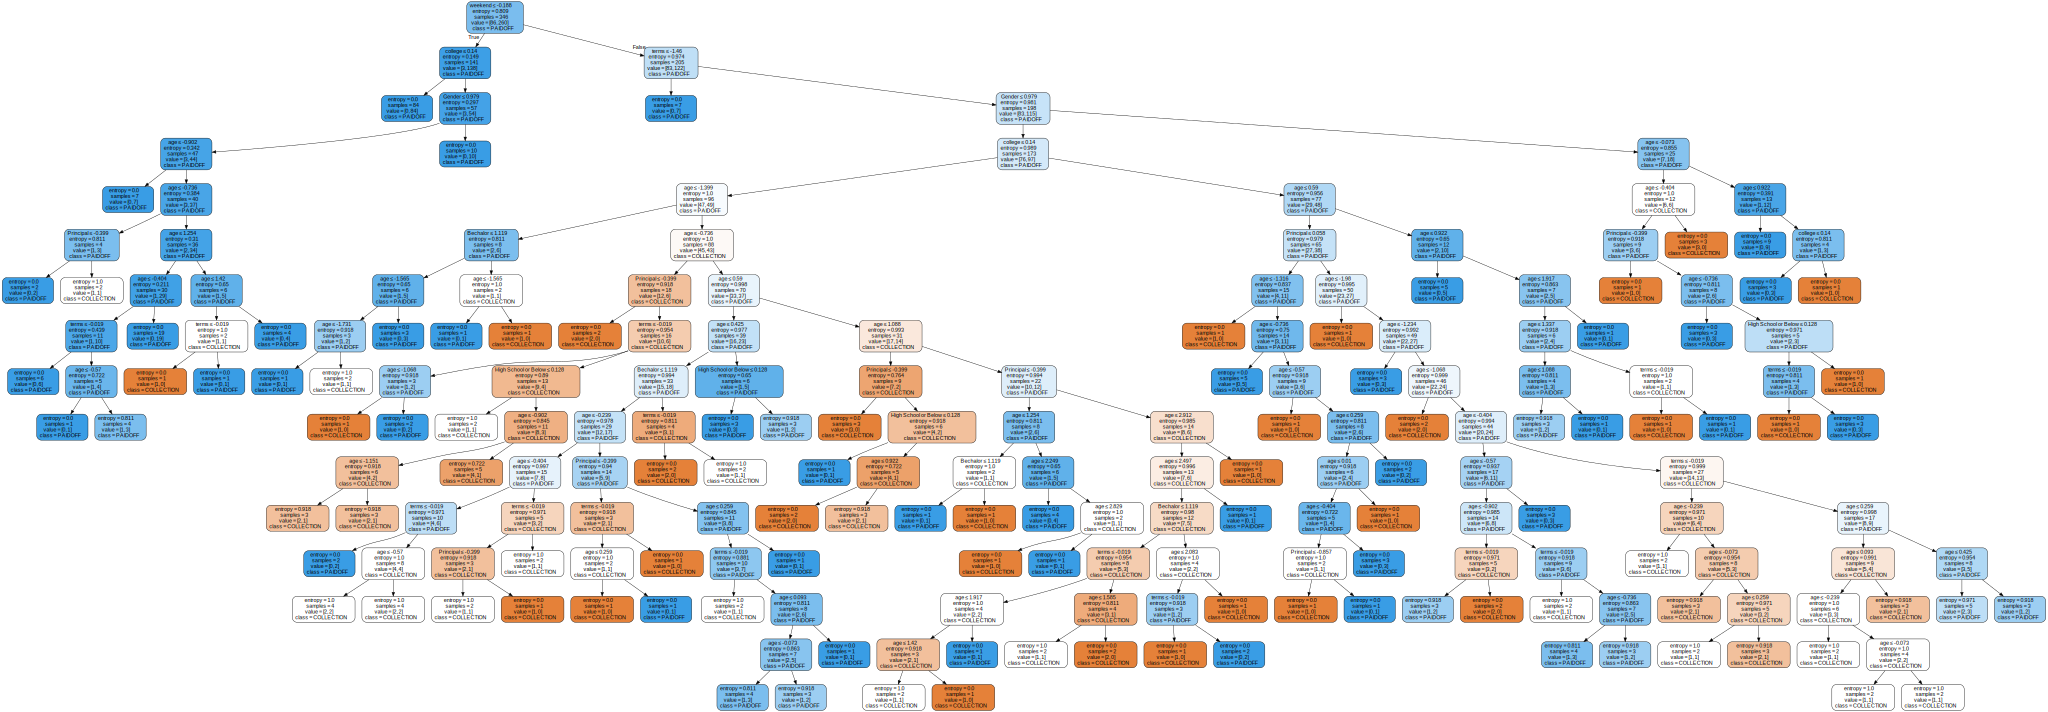

In [28]:
# Plot the decision tree
dot = export_graphviz(dt1, out_file=None, feature_names=feature_names, class_names=target_names, filled=True, rounded=True, special_characters=True) 
graph = Source(dot)
graph

**Analysis:** This decision tree seems to be too complex and performs worse than the KNN model. Looking at the decision tree we can see many leafs with still a high entropy, which means we can expect a large error in these cases. Let's see if we can tweak the model to improve it. 

 ## Decision tree - second attempt
One hypothesis for the not so good performance in detecting COLLECTION cases is that this dataset is unbalanced, i.e., approximately 25% of the cases are labelled COLLECTION and 75% are PAIDOFF, which could bias the model.
An alternative is to use the 'balanced' mode for class_weight parameter of the algorithm, which will use values of y to automatically adjust weights inversely proportional to class frequencies in the input data. This will give higher importance for the COLLECTION cases. Let's see if this change can improve the algorithm:

In [29]:
# Build and train decision tree model
dt2 = DecisionTreeClassifier(criterion="entropy", class_weight='balanced')
eval_model(dt2, X, y, "Decision Tree #2")

Decision Tree #2: scores=[0.51760797 0.4704379  0.7074761  0.81771337 0.81008192]  mean_f1score=0.6646634505271376


0.6646634505271376

In [30]:
dt2.fit(X,y)
print("Decision Tree #2 max_depth=", dt2.tree_.max_depth)

Decision Tree #2 max_depth= 15


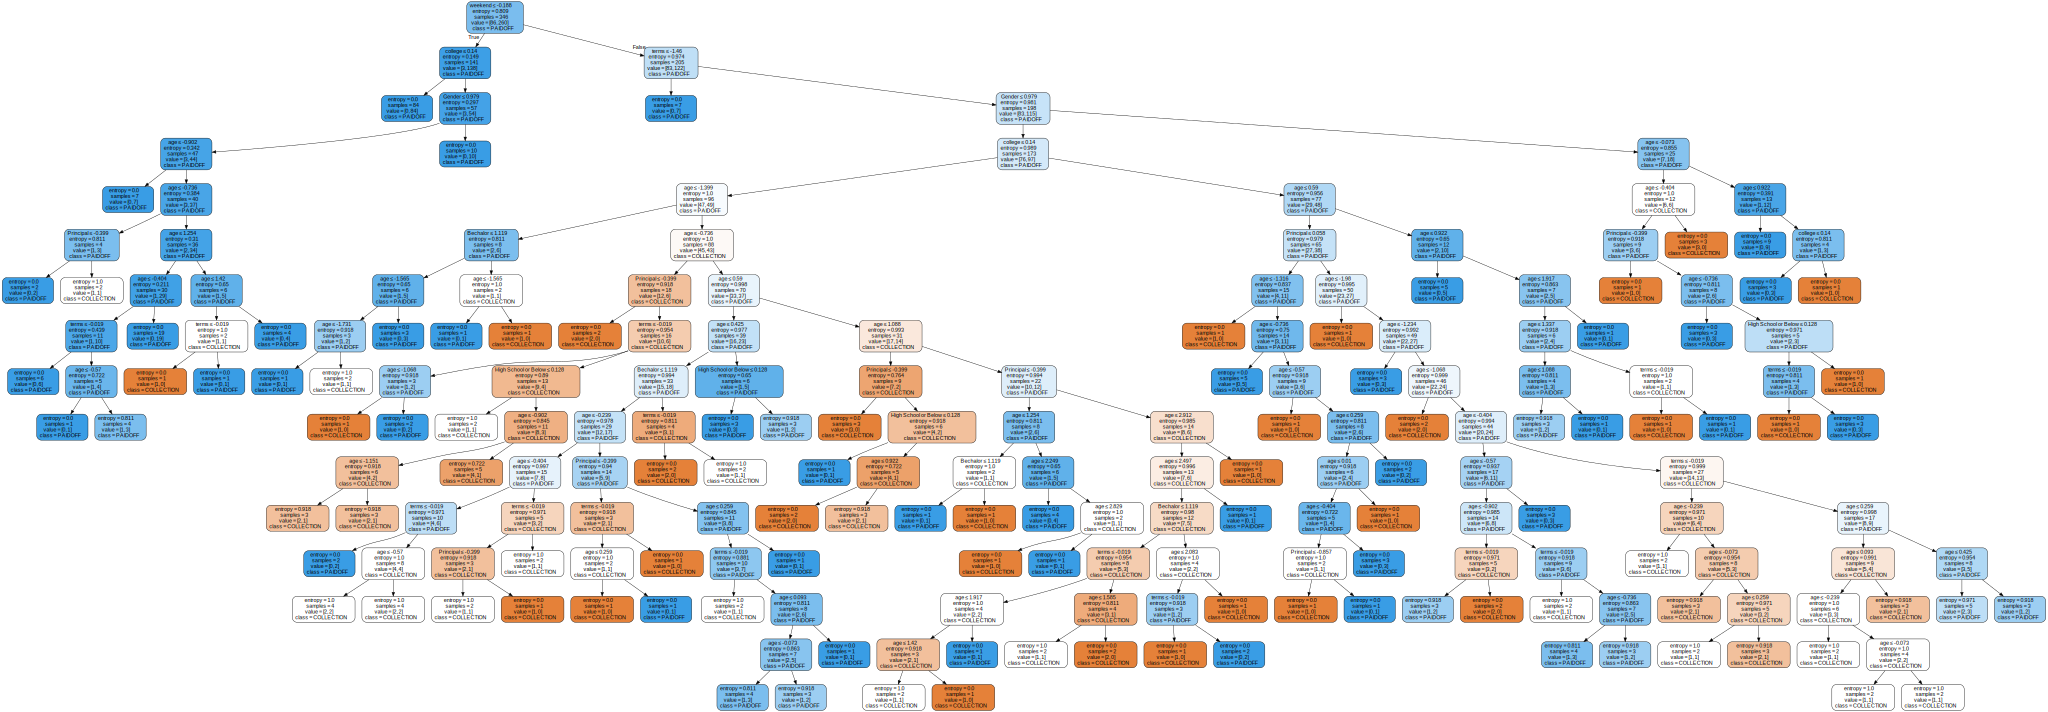

In [31]:
# Plot the decision tree
dot2 = export_graphviz(dt2, out_file=None, feature_names=feature_names, class_names=target_names, filled=True, rounded=True, special_characters=True) 
graph2 = Source(dot)
graph2

**Analysis:** The average weighted f1-score of the second decision tree is worse than the first. Let's see if we can further improve the model.  


## Decision Tree - Third Attempt

In this third attempt to improve the model, let's explore the effect of the decision tree depth on the accuracy.

In [32]:
# Specify the max_depth limits for the iteration
min_depth = 2
max_depth = 30

# Create a dataframe to hold the results
depth_values = []
mean_f1scores = []

# Iterate through different max_depth values and get the model's metrics 
for depth in range(min_depth, max_depth+1):
    dt = DecisionTreeClassifier(criterion="entropy", max_depth=depth)
    mean_score = eval_model(dt, X, y, f"Decision Tree #3 (max_depth={depth})")
    depth_values.append(depth)
    mean_f1scores.append(mean_score)

Decision Tree #3 (max_depth=2): scores=[0.5313381  0.15554789 0.64774224 0.64774224 0.64774224]  mean_f1score=0.5260225451410305
Decision Tree #3 (max_depth=3): scores=[0.55817203 0.31734007 0.64774224 0.64774224 0.64774224]  mean_f1score=0.5637477667877444
Decision Tree #3 (max_depth=4): scores=[0.37964519 0.26895366 0.64774224 0.64774224 0.64774224]  mean_f1score=0.5183651179370055
Decision Tree #3 (max_depth=5): scores=[0.50365164 0.30518018 0.72997712 0.71686884 0.64774224]  mean_f1score=0.580684004449693
Decision Tree #3 (max_depth=6): scores=[0.48945578 0.31734007 0.77568268 0.6910513  0.6805153 ]  mean_f1score=0.59080902645597
Decision Tree #3 (max_depth=7): scores=[0.53820346 0.31734007 0.76319494 0.74102079 0.6805153 ]  mean_f1score=0.6080549119017928
Decision Tree #3 (max_depth=8): scores=[0.49080842 0.30824445 0.77228379 0.70649023 0.6805153 ]  mean_f1score=0.5916684376976707
Decision Tree #3 (max_depth=9): scores=[0.62339245 0.31884058 0.75995238 0.75213544 0.73812331]  mea

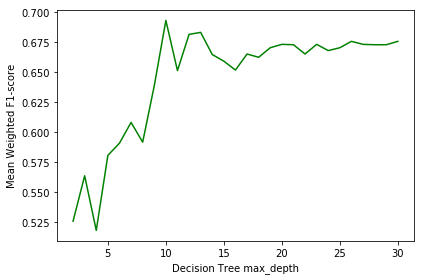

In [33]:
# Plot the accuracy of the model as a function of max_depth, to analyze if there is a trend
plt.plot(depth_values, mean_f1scores,'g')
plt.ylabel('Mean Weighted F1-score')
plt.xlabel('Decision Tree max_depth')
plt.tight_layout()
plt.show()

In [34]:
# Determines the best max_depth/score pair
max_score = 0.0
best_depth = 0
for depth, score in zip(depth_values, mean_f1scores) :
    if score > max_score :
        max_score = score
        best_depth = depth
        
print(f"The best max_depth is {best_depth} => Mean F1-score is {max_score}")

# So, let's build the tree with this max_depth to see the metrics
dt_final = DecisionTreeClassifier(criterion="entropy", max_depth=best_depth)
dt_final.fit( X, y )
print("Decision Tree #3 max_depth=", dt_final.tree_.max_depth)

The best max_depth is 10 => Mean F1-score is 0.6928034470124478
Decision Tree #3 max_depth= 10


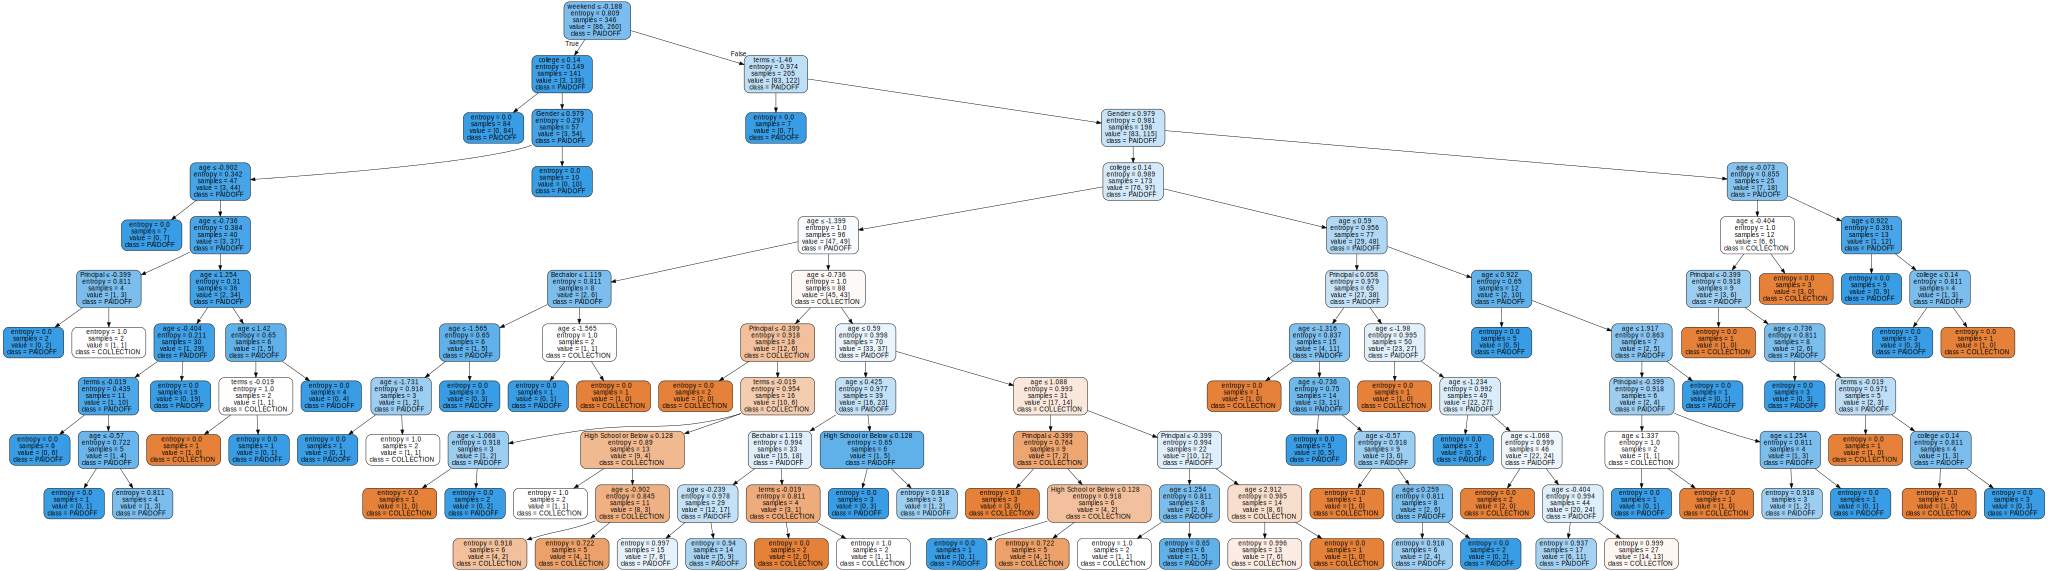

In [35]:
# Plot the decision tree
dot = export_graphviz(dt_final, out_file=None, feature_names=feature_names, class_names=target_names, filled=True, rounded=True, special_characters=True) 
graph = Source(dot)
graph

## Analysis - Decision Tree
Using the strategy to evaluate each model by cross validation and averaging the weighted F1-score of each run, I've made three attempts to model the classifier with Decision Trees:

In the first attempt, I let the KNN classifier choose the tree depth. The resulting tree is **15 level depth**, and score is **0.6697491688900573**.

In the second attempt, I let the KNN classifier choose the tree depth, but tried to use the balanced mode, to compensate for the unbalanced number of COLLECTION and PAIDOFF in the dataset. The resulting tree is **15 level depth**, and score is **0.6646634505271376**.

In the third attempt, I analyzed the effect of the maximum tree depth on the score. The analysis showed that the best score was achieved with a tree **10 level depth** and score is **0.6928456661101224**

 # Support Vector Machine

For the Support Vector Machine, there are a few kernel functions available and no easy way to know which one will perform better beforehand. So, let's try with each one:

## SVM - RBF kernel

In [36]:
# Import the necessary objects
from sklearn import svm

# Create the SVM model with Radial Based Function kernel function
# and run the cross validation
svm1 = svm.SVC(kernel='rbf')
eval_model( svm1, X, y, "SVM(rbf)")

SVM(rbf): scores=[0.63176354 0.66981045 0.64774224 0.64774224 0.64774224]  mean_f1score=0.648960143908304


0.648960143908304

## SVM - Linear kernel

In [37]:
# Create the SVM model with Linear kernel function
# and run the cross validation
svm2 = svm.SVC(kernel='linear')
eval_model(svm2, X, y, 'SVM(linear)')

SVM(linear): scores=[0.5313381  0.46077515 0.64774224 0.64774224 0.64774224]  mean_f1score=0.5870679972294857


0.5870679972294857

## SVM - Polynomial kernel

In [38]:
# Create the SVM model with Polynomial kernel function
# and run the cross validation
svm3 = svm.SVC(kernel='poly')
eval_model(svm3, X, y, "SVM(poly)")

SVM(poly): scores=[0.71290745 0.66580784 0.64057971 0.6805153  0.64774224]  mean_f1score=0.6695105086108029


0.6695105086108029

## SVM - Sigmoid kernel

In [39]:
# Create the SVM model with Sigmoid kernel function
# and run the cross validation
svm4 = svm.SVC(kernel='sigmoid')
eval_model(svm4, X, y, "SVM(Sigmoid)")

SVM(Sigmoid): scores=[0.57018634 0.43865061 0.64057971 0.64057971 0.64774224]  mean_f1score=0.5875477214805278


0.5875477214805278

## Analysis - SVM
The analysis studied the effect of different kernel functions for the SVM model. Here is a summary for this dataset:

RBF (Radial Basis Function): score **0.648960143908304**

Linear kernel: score **0.5870679972294857**

Polynomial kernel: score **0.6695105086108029**

Sigmoid kernel: score **0.5875477214805278**

The best performance was achieved by the Polynomial kernel.

In [40]:
# Instantiate and train the final model with the full data set
svm_final = svm.SVC(kernel='poly')
svm_final.fit(X, y) 

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
  kernel='poly', max_iter=-1, probability=False, random_state=None,
  shrinking=True, tol=0.001, verbose=False)

 # Logistic Regression

With Logistic Regression models, we have some different parameters to tweak. I'll try to change the solver algorithm, and also set the "C" constant to influence the performance. Let's analyze how both parameters influence the model performance:

In [41]:
# Import the LogisticRegression object
from sklearn.linear_model import LogisticRegression

# Define the values of the regularization constant 'C' that we're going to use
c_values = [0.01, 1.0, 10.0, 100.0]
solvers = ['liblinear', 'newton-cg', 'saga', 'lbfgs']

best_model = ()
best_score = 0.0

# Iterate through different solvers and C regularization constant values and get the model's metrics 
for s in solvers:
    for c in c_values:
        lr = LogisticRegression( C=c, solver=s )
        mean_score = eval_model( lr, X, y, f"LR({s},C={c})")
        
        # Compute the best model
        if mean_score > best_score :
            best_score = mean_score
            best_model = (s,c)

LR(liblinear,C=0.01): scores=[0.61107872 0.51396127 0.64057971 0.64774224 0.64774224]  mean_f1score=0.6122208365485526
LR(liblinear,C=1.0): scores=[0.66742857 0.54129117 0.6910513  0.64774224 0.64774224]  mean_f1score=0.6390511065862844
LR(liblinear,C=10.0): scores=[0.65904031 0.55463944 0.6910513  0.64774224 0.64774224]  mean_f1score=0.6400431087514894
LR(liblinear,C=100.0): scores=[0.64686147 0.55463944 0.6910513  0.64774224 0.64774224]  mean_f1score=0.6376073406516121
LR(newton-cg,C=0.01): scores=[0.63325527 0.64774224 0.64774224 0.64774224 0.64774224]  mean_f1score=0.64484484952832
LR(newton-cg,C=1.0): scores=[0.6512893  0.56779388 0.64057971 0.64774224 0.64774224]  mean_f1score=0.6310294769794632
LR(newton-cg,C=10.0): scores=[0.65904031 0.55463944 0.6910513  0.64774224 0.64774224]  mean_f1score=0.6400431087514894
LR(newton-cg,C=100.0): scores=[0.64686147 0.55463944 0.6910513  0.64774224 0.64774224]  mean_f1score=0.6376073406516121
LR(saga,C=0.01): scores=[0.63325527 0.64774224 0.6

In [42]:
# Print the best model
print(f"The best model is SVM({best_model[0]}) => Mean f1-score={best_model[1]}")

The best model is SVM(newton-cg) => Mean f1-score=0.01


In [43]:
lr_final = LogisticRegression( C=best_model[1], solver=best_model[0] )
lr_final.fit( X, y )

LogisticRegression(C=0.01, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='newton-cg',
          tol=0.0001, verbose=0, warm_start=False)

## Analysis - Logistic Regression
For Logistic Regression, the analysis was done to evaluate the effects of both the solver and C regularization constant on the score of the model, evaluating the average weighted f1-score with cross validation.

Three models have achieved the same score: LR(newton-cg,C=0.01), LR(saga,C=0.01) and LR(lbfgs,C=0.01), score **0.64484484952832**.
I'll choose the LR(newton-cg,C=0.01) for the model evaluation using the test set.

# Model Evaluation using Test set

In [44]:
from sklearn.metrics import jaccard_similarity_score
from sklearn.metrics import f1_score
from sklearn.metrics import log_loss

First, download and load the test set:

In [45]:
!wget -O loan_test.csv https://s3-api.us-geo.objectstorage.softlayer.net/cf-courses-data/CognitiveClass/ML0101ENv3/labs/loan_test.csv

--2020-08-04 13:54:21--  https://s3-api.us-geo.objectstorage.softlayer.net/cf-courses-data/CognitiveClass/ML0101ENv3/labs/loan_test.csv
Resolving s3-api.us-geo.objectstorage.softlayer.net (s3-api.us-geo.objectstorage.softlayer.net)... 67.228.254.196
Connecting to s3-api.us-geo.objectstorage.softlayer.net (s3-api.us-geo.objectstorage.softlayer.net)|67.228.254.196|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3642 (3.6K) [text/csv]
Saving to: ‘loan_test.csv’

100%[======================================>] 3,642       --.-K/s   in 0s      

2020-08-04 13:54:21 (496 MB/s) - ‘loan_test.csv’ saved [3642/3642]



### Load Test set for evaluation 

In [46]:
test_df = pd.read_csv('loan_test.csv')
test_df.head()

,Unnamed: 0,Unnamed: 0.1,loan_status,Principal,terms,effective_date,due_date,age,education,Gender
0,1,1,PAIDOFF,1000,30,9/8/2016,10/7/2016,50,Bechalor,female
1,5,5,PAIDOFF,300,7,9/9/2016,9/15/2016,35,Master or Above,male
2,21,21,PAIDOFF,1000,30,9/10/2016,10/9/2016,43,High School or Below,female
3,24,24,PAIDOFF,1000,30,9/10/2016,10/9/2016,26,college,male
4,35,35,PAIDOFF,800,15,9/11/2016,9/25/2016,29,Bechalor,male


In [47]:
# Preprocess the test set in the same way we did for training set

# Convert due_date and effective_date features to datatime type
test_df['due_date'] = pd.to_datetime(df['due_date'])
test_df['effective_date'] = pd.to_datetime(df['effective_date'])

# Create a dayofweek and weekend features
test_df['dayofweek'] = test_df['effective_date'].dt.dayofweek
test_df['weekend'] = test_df['dayofweek'].apply(lambda x: 1 if (x>3)  else 0)

# Replace male/female by 0/1 numeric values
test_df['Gender'].replace(to_replace=['male','female'], value=[0,1],inplace=True)

# Select only the features that we want to consider
X_test = test_df[['Principal','terms','age','Gender','weekend']]

# Use one-hot encoding to replace categorical values with dummies
X_test = pd.concat([X_test, pd.get_dummies(test_df['education'])], axis=1)
X_test.drop(['Master or Above'], axis = 1,inplace=True)
X_test.head()

# Normalize data and extract the arrays
X_test = preprocessing.StandardScaler().fit(X_test).transform(X_test)
y_test = test_df['loan_status'].values

In [48]:
from sklearn.metrics import classification_report, confusion_matrix

# Define a function to print some classification statistics and 
# plot the confusion matrix, that will be used to evaluate our models
def plot_confusion_matrix( y_true, y_pred, 
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    """
    
    # Compute confusion matrix
    classes = np.unique(y_true)
    cm = confusion_matrix(y_true, y_pred, labels=classes)
    np.set_printoptions(precision=2)

    print (classification_report(y_true, y_pred))
    
    plt.figure()
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

## KNN

              precision    recall  f1-score   support

  COLLECTION       0.25      0.14      0.18        14
     PAIDOFF       0.74      0.85      0.79        40

   micro avg       0.67      0.67      0.67        54
   macro avg       0.49      0.50      0.49        54
weighted avg       0.61      0.67      0.63        54



,Algorithm,Jaccard,F1-score,Log Loss
0,KNN,0.666667,0.63284,NA


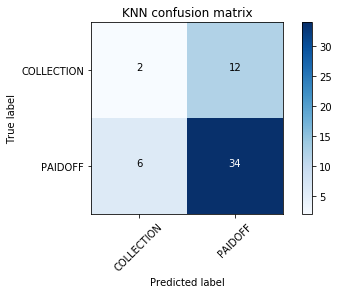

In [49]:
# Now, let's use use the final models of each type (KNN, Decision Tree, SVM, LR) that were created in the previous sections 
# to process the test set and calculate the metrics

# KNN
y_pred_knn = knn_final.predict( X_test )
plot_confusion_matrix( y_test, y_pred_knn, title='KNN confusion matrix' )

jaccard_knn = jaccard_similarity_score( y_true=y_test, y_pred=y_pred_knn )
f1score_knn = f1_score( y_true=y_test, y_pred=y_pred_knn, average='weighted' )  

knn_report = pd.DataFrame( { 'Algorithm':['KNN'], 'Jaccard':[jaccard_knn], 'F1-score':[f1score_knn], 'Log Loss':['NA'] }  )
knn_report

## Decision Tree

              precision    recall  f1-score   support

  COLLECTION       0.30      0.43      0.35        14
     PAIDOFF       0.76      0.65      0.70        40

   micro avg       0.59      0.59      0.59        54
   macro avg       0.53      0.54      0.53        54
weighted avg       0.64      0.59      0.61        54



,Algorithm,Jaccard,F1-score,Log Loss
0,Decision Tree,0.592593,0.612024,NA


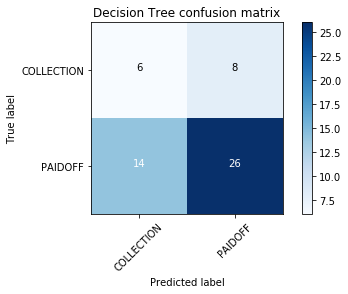

In [50]:
#Decision Tree
y_pred_dt = dt_final.predict( X_test )
plot_confusion_matrix( y_test, y_pred_dt, title='Decision Tree confusion matrix' )

jaccard_dt = jaccard_similarity_score( y_true=y_test, y_pred=y_pred_dt )
f1score_dt = f1_score( y_true=y_test, y_pred=y_pred_dt, average='weighted' )  

dt_report = pd.DataFrame( { 'Algorithm':['Decision Tree'], 'Jaccard':[jaccard_dt], 'F1-score':[f1score_dt], 'Log Loss':['NA'] } )
dt_report

## Support Vector Machine

              precision    recall  f1-score   support

  COLLECTION       0.00      0.00      0.00        14
     PAIDOFF       0.74      1.00      0.85        40

   micro avg       0.74      0.74      0.74        54
   macro avg       0.37      0.50      0.43        54
weighted avg       0.55      0.74      0.63        54



,Algorithm,Jaccard,F1-score,Log Loss
0,SVM,0.740741,0.630418,NA


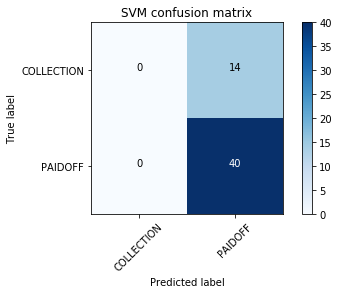

In [51]:
y_pred_svm = svm_final.predict( X_test )
plot_confusion_matrix( y_test, y_pred_svm, title='SVM confusion matrix' )

jaccard_svm = jaccard_similarity_score( y_true=y_test, y_pred=y_pred_svm )
f1score_svm = f1_score( y_true=y_test, y_pred=y_pred_svm, average='weighted' )  

svm_report = pd.DataFrame( {'Algorithm':['SVM'], 'Jaccard':[jaccard_svm], 'F1-score':[f1score_svm], 'Log Loss':['NA'] }  )
svm_report

## Logistic Regression

              precision    recall  f1-score   support

  COLLECTION       0.00      0.00      0.00        14
     PAIDOFF       0.74      1.00      0.85        40

   micro avg       0.74      0.74      0.74        54
   macro avg       0.37      0.50      0.43        54
weighted avg       0.55      0.74      0.63        54



,Algorithm,Jaccard,F1-score,Log Loss
0,Logistic Regression,0.740741,0.630418,0.554638


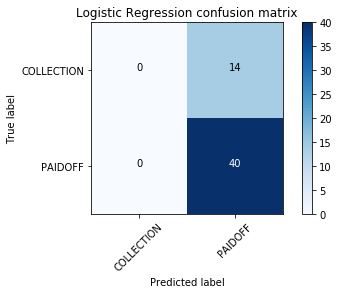

In [52]:
y_pred_lr = lr_final.predict( X_test )
y_proba_lr = lr_final.predict_proba( X_test )
plot_confusion_matrix( y_test, y_pred_lr, title='Logistic Regression confusion matrix' )

jaccard_lr = jaccard_similarity_score( y_true=y_test, y_pred=y_pred_lr )
f1score_lr = f1_score( y_true=y_test, y_pred=y_pred_lr, average='weighted' )  
logloss_lr = log_loss( y_true=y_test, y_pred=y_proba_lr )

lr_report = pd.DataFrame( {'Algorithm':['Logistic Regression'], 'Jaccard':[jaccard_lr], 'F1-score':[f1score_lr], 'Log Loss':[logloss_lr] }, )
lr_report

# Report
You should be able to report the accuracy of the built model using different evaluation metrics:

| Algorithm          | Jaccard | F1-score | LogLoss |
|--------------------|---------|----------|---------|
| KNN                | ?       | ?        | NA      |
| Decision Tree      | ?       | ?        | NA      |
| SVM                | ?       | ?        | NA      |
| LogisticRegression | ?       | ?        | ?       |

In [53]:
# Create a report DataFrame to print the results
report = pd.DataFrame()
report = report.append(knn_report).append(dt_report).append(svm_report).append(lr_report)
report

,Algorithm,Jaccard,F1-score,Log Loss
0,KNN,0.666667,0.632840,NA
0,Decision Tree,0.592593,0.612024,NA
0,SVM,0.740741,0.630418,NA
0,Logistic Regression,0.740741,0.630418,0.554638


## Conclusion
Looking at this table alone it is hard to evaluate which model has a better performance. At first sight, the SVM and Logistic Regression models have F1-score slightly worse than the KNN, but have better Jaccard indexes, which could lead to the conclusion that they are better. But, looking more carefully at their confusion matrices, we can see that SVM and LR are unable to predict COLLECTION cases for the test set! So, they are probably not good choices for this problem.

Considering the KNN and Decision Tree models, KNN performs better at predicting the PAIDOFF cases, whereas the Decision Tree performs better at predicting the COLLECTION cases.

<h2>Want to learn more?</h2>

IBM SPSS Modeler is a comprehensive analytics platform that has many machine learning algorithms. It has been designed to bring predictive intelligence to decisions made by individuals, by groups, by systems – by your enterprise as a whole. A free trial is available through this course, available here: <a href="http://cocl.us/ML0101EN-SPSSModeler">SPSS Modeler</a>

Also, you can use Watson Studio to run these notebooks faster with bigger datasets. Watson Studio is IBM's leading cloud solution for data scientists, built by data scientists. With Jupyter notebooks, RStudio, Apache Spark and popular libraries pre-packaged in the cloud, Watson Studio enables data scientists to collaborate on their projects without having to install anything. Join the fast-growing community of Watson Studio users today with a free account at <a href="https://cocl.us/ML0101EN_DSX">Watson Studio</a>

<h3>Thanks for completing this lesson!</h3>

<h4>Author:  <a href="https://ca.linkedin.com/in/saeedaghabozorgi">Saeed Aghabozorgi</a></h4>
<p><a href="https://ca.linkedin.com/in/saeedaghabozorgi">Saeed Aghabozorgi</a>, PhD is a Data Scientist in IBM with a track record of developing enterprise level applications that substantially increases clients’ ability to turn data into actionable knowledge. He is a researcher in data mining field and expert in developing advanced analytic methods like machine learning and statistical modelling on large datasets.</p>

<hr>

<p>Copyright &copy; 2018 <a href="https://cocl.us/DX0108EN_CC">Cognitive Class</a>. This notebook and its source code are released under the terms of the <a href="https://bigdatauniversity.com/mit-license/">MIT License</a>.</p>